# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os
from torchvision.utils import make_grid

## load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
real            = torch.from_numpy(data['real_images']).float()

## hyper-parameters

In [3]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 100
size_minibatch  = 50
dim_latent      = 50
dim_channel     = 1
learning_rate_discriminator = 0.001
learning_rate_generator     = 0.001

## custom data loader for the PyTorch framework

In [4]:
class dataset (Dataset):
    def  __init__(self, data):

        self.data = data

    def __getitem__(self, index):

        data = self.data[index]
        data = torch.FloatTensor(data).unsqueeze(dim=0)

        return data
  
    def __len__(self):
        
        return self.data.shape[0]

## construct datasets and dataloaders for training and testing

In [5]:
dataset_real    = dataset(real)
dataloader_real = DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

## shape of the data when using the data loader

In [6]:
image_real = dataset_real[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_real.shape)
print('*******************************************************************')

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 32, 32])
*******************************************************************


## class for the neural network 

In [7]:
class Discriminator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=8):
        
		super(Discriminator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2
		
		self.feature = nn.Sequential(
			# ================================================================================
			nn.Conv2d(in_channel, dim_feature * 1, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 1, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 2, dim_feature * 4, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 4, dim_feature * 8, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 8, dim_feature * 16, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
		)	
		
		self.classifier = nn.Sequential(
			# ================================================================================
			nn.Linear(dim_feature * 16, dim_feature * 8, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 8, dim_feature * 4, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 4, dim_feature * 2, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 2, dim_feature * 1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 1, out_channel, bias=True),
			# ================================================================================
		) 

		self.network = nn.Sequential(
			self.feature,
			nn.Flatten(),
			self.classifier,
		)

		self.initialize_weight()

		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		y = self.network.forward(x)

		return y

	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass

In [8]:
class Generator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=8):
        
		super(Generator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2

		self.network = nn.Sequential(
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(in_channel, dim_feature * 8, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 8),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 8, dim_feature * 4, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 4),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 4, dim_feature * 2, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 2),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 2, dim_feature * 1, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 1),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 1, out_channel, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(out_channel),
			# ================================================================================
			nn.Sigmoid(),
			# ================================================================================
		) 			

		self.initialize_weight()
		
		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		y = self.network.forward(x)

		return y

	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass


## build network

In [9]:
generator       = Generator(dim_latent, 1, 8).to(device)
discriminator   = Discriminator(dim_channel, 1, 8).to(device)

optimizer_generator     = torch.optim.Adam(generator.parameters(), lr=learning_rate_generator, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_discriminator, betas=(0.5, 0.999))

initialize model parameters : xavier_uniform
initialize model parameters : xavier_uniform


## compute the prediction

In [10]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [11]:
def compute_loss_discriminator(generator, discriminator, latent, data_real):

    data_fake       = compute_prediction(generator, latent)
    prediction_real = compute_prediction(discriminator, data_real)
    prediction_fake = compute_prediction(discriminator, data_fake)

    criterion   = nn.BCEWithLogitsLoss()
    
    label_real  = torch.ones_like(prediction_real)
    label_fake  = torch.zeros_like(prediction_fake)

    # ==================================================
    # fill up the blank
    #    
    loss_real = criterion(prediction_real, label_real)
    loss_fake = criterion(prediction_fake, label_fake)
    # 
    # ==================================================

    loss_discriminator = (loss_real + loss_fake) / 2.0

    return loss_discriminator

In [12]:
def compute_loss_generator(generator, discriminator, latent):

    data_fake       = compute_prediction(generator, latent)
    prediction_fake = compute_prediction(discriminator, data_fake)

    criterion       = nn.BCEWithLogitsLoss()

    label_real      = torch.ones_like(prediction_fake)

    # ==================================================
    # fill up the blank
    #    
    loss_generator  = criterion(prediction_fake, label_real)
    # 
    # ==================================================

    return loss_generator

## compute the accuracy

In [13]:
def get_center_index(binary_image):
    
    area_square = np.sum(binary_image)

    height = binary_image.shape[0]
    width = binary_image.shape[1]

    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    indices_X, indices_Y = np.meshgrid(x, y)

    x_mean = np.sum(binary_image * indices_X) / area_square
    y_mean = np.sum(binary_image * indices_Y) / area_square

    return (x_mean, y_mean)

In [14]:
# create ideal square image which has the same area to the input image
def create_label(binary_images):
    
    label = np.zeros_like(binary_images)
    
    for i, binary_image in enumerate(binary_images):
        
        image_height = binary_image.shape[0]
        image_width = binary_image.shape[1]

        square_image = np.zeros((image_height, image_width))
        square_length = np.round(np.sqrt(np.sum(binary_image)))

        if square_length == 0:
            # when there is no square
            return square_image

        (square_center_x, square_center_y) = get_center_index(binary_image)

        if square_center_x < 0 or square_center_x > image_width - 1 or square_center_y < 0 or square_center_y > image_height - 1:
            return square_image

        top = np.ceil(square_center_y - square_length / 2)
        bottom = np.floor(square_center_y + square_length / 2)
        left = np.ceil(square_center_x - square_length / 2)
        right = np.floor(square_center_x + square_length / 2)

        top = int(top) if top >= 0 else 0
        bottom = int(bottom) if bottom <= image_height - 1 else image_height - 1
        left = int(left) if left >= 0 else 0
        right = int(right) if right <= image_width - 1 else image_width - 1

        square_image[top : bottom + 1, left : right + 1] = 1
        
        label[i] = square_image
        
    return label

In [15]:
def compute_accuracy(prediction):

    prediction  = prediction.squeeze(axis=1)
    
    prediction_binary   = (prediction >= 0.5).cpu().numpy().astype(int)
    label               = create_label(prediction_binary).astype(int)
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [16]:
loss_generator_mean     = np.zeros(number_epoch)
loss_generator_std      = np.zeros(number_epoch)
loss_discriminator_mean = np.zeros(number_epoch)
loss_discriminator_std  = np.zeros(number_epoch)

accuracy_mean   = np.zeros(number_epoch)
accuracy_std    = np.zeros(number_epoch)

## train

In [17]:
def train(generator, discriminator, dataloader):

    loss_epoch_generator      = []
    loss_epoch_discriminator  = []
    accuracy_epoch = []
    
    for index_batch, data_real in enumerate(dataloader):

        size_batch  = len(data_real)
        data_real   = data_real.to(device)
        
        latent  = torch.randn(size_batch, dim_latent, device=device)
        latent  = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()

        optimizer_generator.zero_grad()
        loss_generator = compute_loss_generator(generator, discriminator, latent)
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()

        optimizer_discriminator.zero_grad()
        loss_discriminator = compute_loss_discriminator(generator, discriminator, latent, data_real)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        data_fake   = compute_prediction(generator, latent)
        accuracy    = compute_accuracy(data_fake)

        loss_epoch_generator.append(loss_generator.item())
        loss_epoch_discriminator.append(loss_discriminator.item())
        accuracy_epoch.append(accuracy)

    loss_generator_mean_epoch       = np.mean(loss_epoch_generator)
    loss_generator_std_epoch        = np.std(loss_epoch_generator)
    
    loss_discriminator_mean_epoch   = np.mean(loss_epoch_discriminator)
    loss_discriminator_std_epoch    = np.std(loss_epoch_discriminator)

    accuracy_mean_epoch             = np.mean(accuracy_epoch)
    accuracy_std_epoch              = np.std(accuracy_epoch)

    loss_value_generator        = {'mean' : loss_generator_mean_epoch, 'std' : loss_generator_std_epoch}
    loss_value_discriminator    = {'mean' : loss_discriminator_mean_epoch, 'std' : loss_discriminator_std_epoch}
    accuracy_value              = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch} 

    return loss_value_generator, loss_value_discriminator, accuracy_value


## training epoch

In [18]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_value_generator, loss_value_discriminator, accuracy_value) = train(generator, discriminator, dataloader_real)

    loss_generator_mean[i]      = loss_value_generator['mean']
    loss_generator_std[i]       = loss_value_generator['std']

    loss_discriminator_mean[i]  = loss_value_discriminator['mean']
    loss_discriminator_std[i]   = loss_value_discriminator['std']

    accuracy_mean[i]            = accuracy_value['mean']
    accuracy_std[i]             = accuracy_value['std']

100%|██████████| 100/100 [13:13<00:00,  7.93s/it]


---

# functions for visualizing the results 

---

## plot curve

In [19]:
def plot_image_grid(data, nRow, nCol, filename=None):

    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))
    
    data = data.detach().cpu()

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            image   = np.squeeze(data[k], axis=0)

            axes[i, j].imshow(image, cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

In [20]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [21]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [22]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title, filename=None):

    fig = plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

In [23]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [24]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [25]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [26]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [27]:
def function_result_01():

    print('[plot examples of the real images]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_real)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    data = dataset_real[index_data]
    data = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [28]:
def function_result_02():

    print('[plot examples of the fake images]')
    print('') 

    nRow = 8
    nCol = 6
    number_latent = nRow * nCol

    latent  = torch.randn(number_latent, dim_latent, device=device)
    latent  = torch.reshape(latent, [number_latent, dim_latent, 1, 1])

    generator.eval()

    data_fake   = generator(latent)
    filename    = 'fake_image.png'

    plot_image_grid(data_fake, nRow, nCol, filename)

In [29]:
def function_result_03():

    print('[plot the generator loss]')
    print('') 

    plot_curve_error(loss_generator_mean, loss_generator_std, 'epoch', 'loss', 'generator loss', 'loss_generator.png')

In [30]:
def function_result_04():
    
    print('[plot the discriminator loss]')
    print('') 
    
    plot_curve_error(loss_discriminator_mean, loss_discriminator_std, 'epoch', 'loss', 'discriminator loss', 'loss_discriminator.png')

In [31]:
def function_result_05():
    
    print('[plot the accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean, accuracy_std, 'epoch', 'accuracy', 'training accuracy', 'training_accuracy.png')

In [32]:
def function_result_06():
    
    print('[print the generator loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_generator_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [33]:
def function_result_07():
    
    print('[print the discriminator loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_discriminator_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [34]:
def function_result_08():
    
    print('[print the accuracy at the last 10 epochs]')
    print('') 

    data_last = get_data_last(accuracy_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [35]:
def function_result_09():
    
    print('[print the best accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean, -10)
    print('best accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the real images]



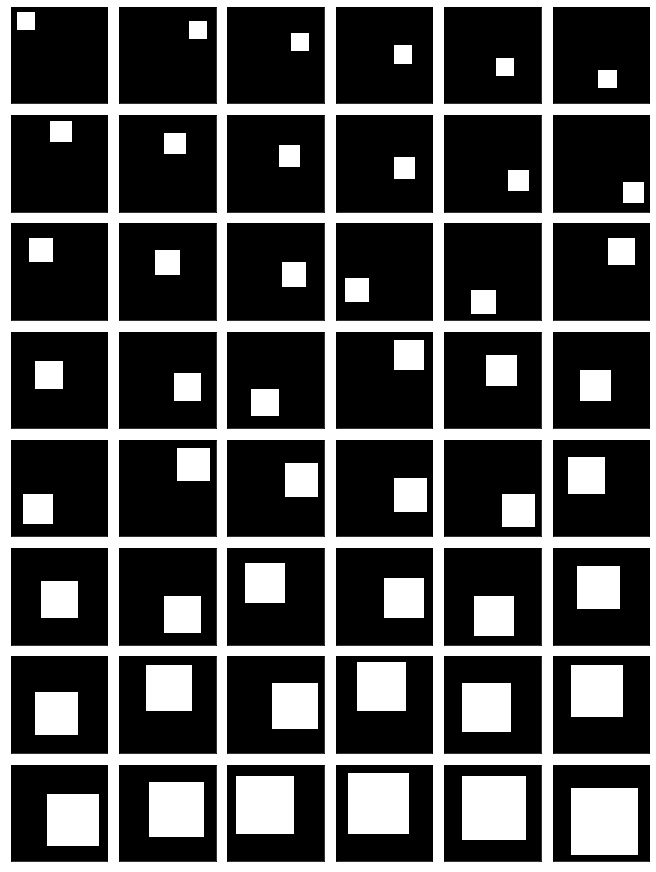


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the fake images]



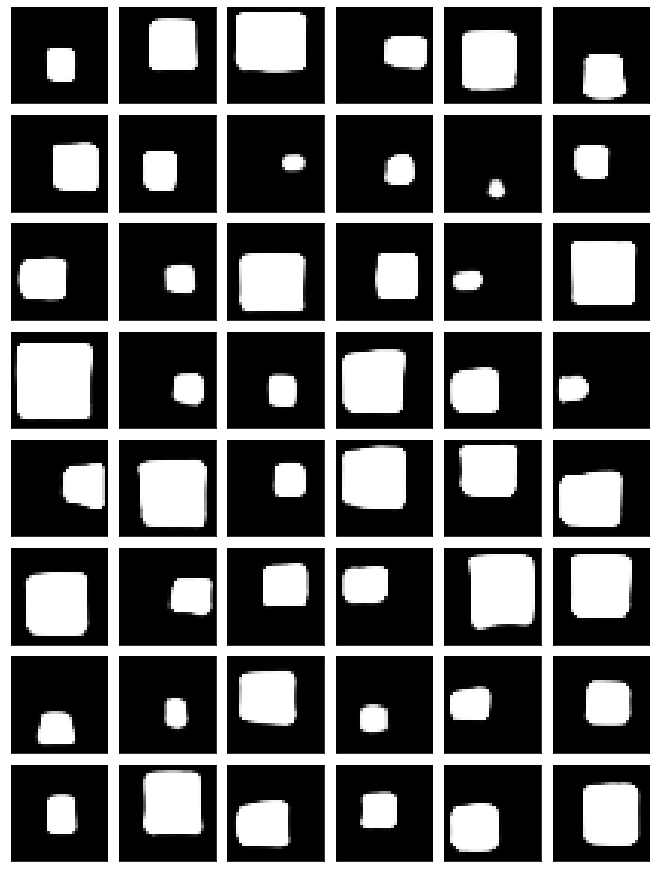


################################################################################
#
# RESULT # 03
#
################################################################################

[plot the generator loss]



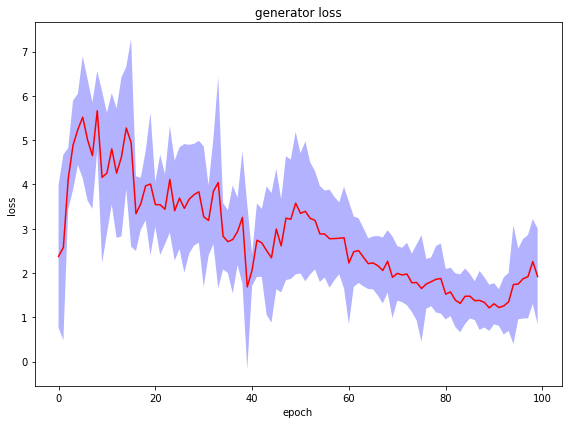


################################################################################
#
# RESULT # 04
#
################################################################################

[plot the discriminator loss]



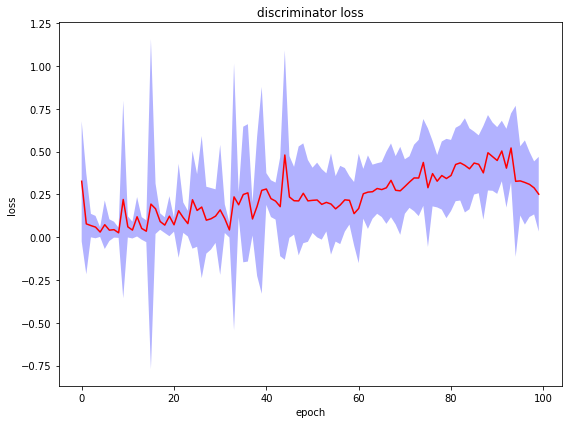


################################################################################
#
# RESULT # 05
#
################################################################################

[plot the accuracy]



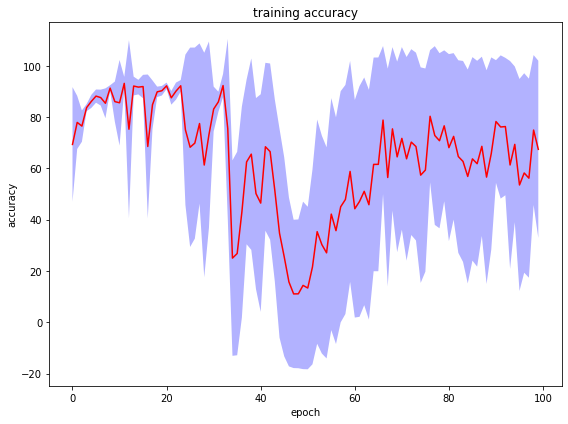


################################################################################
#
# RESULT # 06
#
################################################################################

[print the generator loss at the last 10 epochs]

index =  0, value = 1.3066007748
index =  1, value = 1.2216878249
index =  2, value = 1.2581180551
index =  3, value = 1.3485490479
index =  4, value = 1.7412519069
index =  5, value = 1.7533979773
index =  6, value = 1.8722274456
index =  7, value = 1.9185810231
index =  8, value = 2.2595885483
index =  9, value = 1.9211475357

################################################################################
#
# RESULT # 07
#
################################################################################

[print the discriminator loss at the last 10 epochs]

index =  0, value = 0.4483060475
index =  1, value = 0.5036980825
index =  2, value = 0.4035271009
index =  3, value = 0.5212468469
index =  4, value = 0.3265649731
index =  5, value = 0.3289529003
inde

In [36]:
number_result = 9

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)